In [1]:
%load_ext autoreload
%autoreload 2

import ast
import os
import sys
import requests as req
import json
import multiprocessing as mp


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.plotting.plot import bocd_plot_comp
from curvemetrics.src.classes.model import BOCD

Adding /root/curve-lp-metrics to sys.path


In [2]:
scaler = StandardScaler()
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

In [22]:
pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" # UST pool
start_ts = datetime.timestamp(datetime(2022, 5, 1))
end_ts = datetime.timestamp(datetime(2022, 5, 20))

swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)

tokens = set(swaps_data['tokenBought']).union(set(swaps_data['tokenSold']))
ohlcvs = {}
for token in tokens:
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start_ts, end_ts)

# Aggregate LP Markouts

<Axes: xlabel='timestamp'>

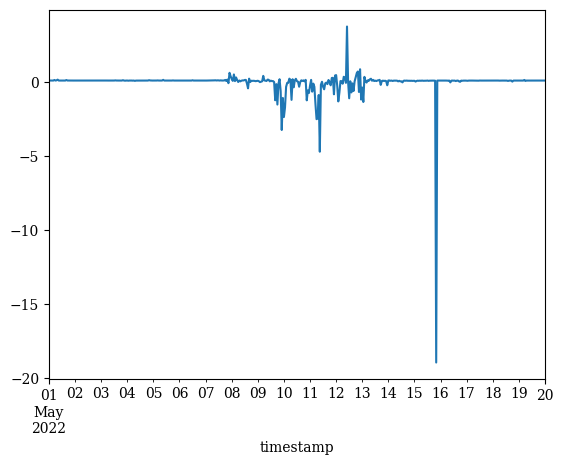

In [4]:
FREQ = '1h'
NORMALIZE = False
STANDARDIZE = True

markouts_agg = datahandler.get_pool_X('300.Markout', pool, start_ts, end_ts, FREQ, normalize=NORMALIZE, standardize=STANDARDIZE)
markouts_agg.plot()

# Individual Taker Markouts

- Input: Period
- Read current takers table
- For each pool:
    - Compute markouts
    - Add markouts to takers table
- Warning: don't double count any swaps

In [46]:
takers = pd.read_csv('../takers.csv')
sharks = takers[takers['cumulativeMarkout'] > takers['cumulativeMarkout'].quantile(0.9)]
print(f'{len(sharks)} sharks of {len(takers)} takers.')
sharks.head()

931 sharks of 9303 takers.


,address,amountBought,amountSold,cumulativeMarkout,meanMarkout,count,windowSize
2,0x0000000000036414940324055c43e75f56b7d016,6.791887e+06,6.680705e+06,3.811329e+04,154.304805,247,86400
3,0x00000000000747d525e898424e8774f7eb317d00,8.151741e+08,8.149493e+08,2.489743e+05,233.559401,1066,86400
5,0x00000000000e1d0dabf7b7c7b68866fc940d0db8,5.445545e+08,5.445309e+08,2.005075e+05,1927.956668,104,86400
6,0x000000000035b5e5ad9019092c665357240f594e,1.103956e+09,1.102305e+09,1.624207e+06,1561.737339,1040,86400
7,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,3.017558e+10,3.016596e+10,9.568739e+06,203.668191,46982,86400


In [6]:
takers.rename({'address':'buyer'}, axis=1, inplace=True)
takers.set_index('buyer', inplace=True)

In [42]:
sharkflow = {}
for token in tokens:
    flow = metricsprocessor.sharkflow(swaps_data, takers, token, token_metadata[token]['symbol'], top=0.9)
    # if len(flow) == 0:
    #     continue
    # flow = flow.resample(FREQ).sum()
    # flow = pd.Series(scaler.fit_transform(flow.values.reshape(-1, 1)).flatten(), index=flow.index)
    sharkflow[token] = flow

In [43]:
list(sharkflow.values())[0]

timestamp
2022-05-01 04:45:00   -236844.524913
2022-05-01 04:46:00         0.000000
2022-05-01 04:47:00         0.000000
2022-05-01 04:48:00         0.000000
2022-05-01 04:49:00         0.000000
                           ...      
2022-05-19 23:49:00         0.000000
2022-05-19 23:50:00         0.000000
2022-05-19 23:51:00     79458.977971
2022-05-19 23:52:00         0.000000
2022-05-19 23:53:00    -79458.977900
Freq: T, Name: UST.sharkflow, Length: 27069, dtype: float64

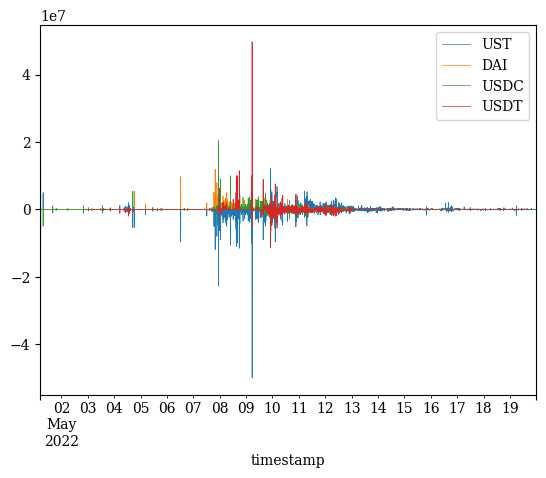

In [40]:
for k, v in sharkflow.items():
    if len(v):
        v.plot(label=token_metadata[k]['symbol'], linewidth=0.5)
plt.legend()

In [169]:
start_ts

1672531200.0

In [161]:
def load_config():
    # Load the configuration
    with open("../config.json", "r") as config_file:
        config = json.load(config_file)
    return config

config = load_config()
token = datahandler.token_ids['frxETH']

token_config = config['token_exchange_map'][token_metadata[token]['symbol']]
api, source, numeraire = token_config

token_data = datahandler.get_curve_price(token, source, start_ts, end_ts, numeraire=datahandler.token_ids[numeraire])

In [170]:
datahandler.format_token_data(token_data)

,token_id,symbol,timestamp,open,high,low,close,volume
0,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1672580,NaN,NaN,NaN,0.997934,0
1,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1672600,NaN,NaN,NaN,0.998073,0
2,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1672606,NaN,NaN,NaN,0.998098,0
3,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1672614,NaN,NaN,NaN,0.998141,0
4,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1672687,NaN,NaN,NaN,0.998211,0
...,...,...,...,...,...,...,...,...
902,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1675201,NaN,NaN,NaN,0.999672,0
903,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1675203,NaN,NaN,NaN,0.999672,0
904,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1675205,NaN,NaN,NaN,0.999672,0
905,0x5e8422345238f34275888049021821e8e08caa1f,frxETH/ETH,1675206,NaN,NaN,NaN,0.999672,0
